In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'

In [3]:
gears_1: np.ndarray = cv2.imread('trybik.jpg')
gears_gray_1: np.ndarray = cv2.cvtColor(gears_1, cv2.COLOR_BGR2GRAY)
gears_2: np.ndarray = cv2.imread('trybiki2.jpg')
gears_gray_2: np.ndarray = cv2.cvtColor(gears_2, cv2.COLOR_BGR2GRAY)

gears_inverted_1: np.ndarray = cv2.bitwise_not(gears_gray_1)
gears_inverted_2: np.ndarray = cv2.bitwise_not(gears_gray_2)

In [4]:
from typing import Tuple, List


def contour(image: np.ndarray) -> Tuple[List, int]:
    _, binary = cv2.threshold(image, 0, 255, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    eroded = cv2.erode(binary, np.full((3, 3), 1), iterations=1)
    
    contours, _ = cv2.findContours(eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    maximum_index = max(range(len(contours)), key=lambda x: contours.__getitem__(x).shape[0])
    
    return contours, maximum_index

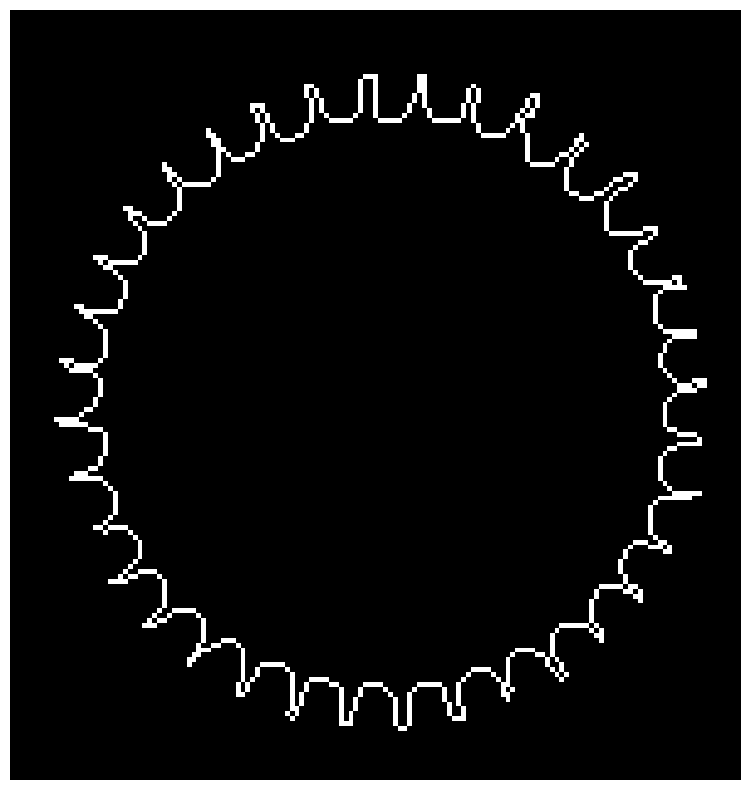

In [5]:
contour_list, max_index = contour(gears_inverted_1)

plt.axis('off')
plt.imshow(
    cv2.drawContours(
        np.zeros(gears_inverted_1.shape[:2], dtype=np.uint8),
        contour_list,
        max_index,
        color=[255]
    ),
    cmap='gray'
)

In [6]:
sobel_x = cv2.Sobel(gears_inverted_1, cv2.CV_64F, 1, 0, ksize=5)
sobel_y = cv2.Sobel(gears_inverted_1, cv2.CV_64F, 0, 1, ksize=5)

gradient_amplitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
gradient_amplitude /= np.amax(gradient_amplitude)
orientation = ((np.degrees(np.arctan2(sobel_y, sobel_x)) + 360) % 360).astype(np.int32)

In [7]:
reference_point = cv2.moments(contour_list[max_index], True)

c = (int(reference_point['m10'] / reference_point['m00']), int(reference_point['m01'] / reference_point['m00']))

In [8]:
r_table = [list() for _ in range(360)]

c_x, c_y = c

for contour in contour_list:
    for contour_x, contour_y in contour.reshape(-1, 2):
        vector = (contour_x - c_x, contour_y - c_y)
        length = np.linalg.norm(vector)
        o_x_angle = np.arctan2(vector[1], vector[0])
        
        r_table[orientation[contour_x, contour_y]].append((length, o_x_angle))

r_table

[[(49.39635614091387, 1.0164888305933455),
  (15.652475842498529, -1.1071487177940904),
  (18.439088914585774, 1.3521273809209546),
  (43.289721643826724, 3.0258334358689827)],
 [(61.40032573203501, -1.2902595350565746),
  (40.311288741492746, 3.017237659043032)],
 [(35.4682957019364, 0.3752708228559573)],
 [(56.92099788303083, -2.819842099193151),
  (59.77457653551382, -2.835713782184941),
  (57.55866572463264, -3.0021525964984557),
  (57.3149195236284, -0.8224182792713783),
  (50.96076922496363, -2.8632929945846817)],
 [(60.00833275470999, -0.016665123713940747),
  (33.52610922848042, -0.3028848683749714)],
 [(58.9406481131655, -0.25732371497108864),
  (39.20459156782532, -0.6588060361174762)],
 [(14.7648230602334, -2.647651284670212),
  (43.68065933568311, -1.2924966677897853)],
 [(57.706152185014034, -1.727398203776912),
  (60.03332407921454, 3.108271657711546)],
 [(62.36184731067546, -1.2946993073994602),
  (50.80354318352215, 0.6316906343389693),
  (20.09975124224178, -3.04192400

In [9]:
sobel_x_2 = cv2.Sobel(gears_inverted_2, cv2.CV_64F, 1, 0, ksize=5)
sobel_y_2 = cv2.Sobel(gears_inverted_2, cv2.CV_64F, 0, 1, ksize=5)

gradient_amplitude_2 = np.sqrt(sobel_x_2 ** 2 + sobel_y_2 ** 2)
gradient_amplitude_2 /= np.amax(gradient_amplitude_2)

orientation_2 = ((np.degrees(np.arctan2(sobel_y_2, sobel_x_2)) + 360) % 360).astype(np.int32)

In [10]:
image_size_x, image_size_y = gradient_amplitude_2.shape

hough_space: np.ndarray = np.zeros((image_size_x, image_size_y, 2), dtype=np.uint8)

for x_index in range(image_size_x):
    for y_index in range(image_size_y):
        if gradient_amplitude_2[x_index, y_index] <= 0.5:
            continue
        
        angle = orientation_2[x_index, y_index]
        for radius, alpha in r_table[angle]:
            x1 = int(x_index - radius * np.cos(alpha))
            y1 = int(y_index - radius * np.sin(alpha))
            
            if 0 <= x1 < image_size_x and 0 <= y1 < image_size_y:
                hough_space[x1, y1, 0] += 1
                hough_space[x1, y1, 1] = angle

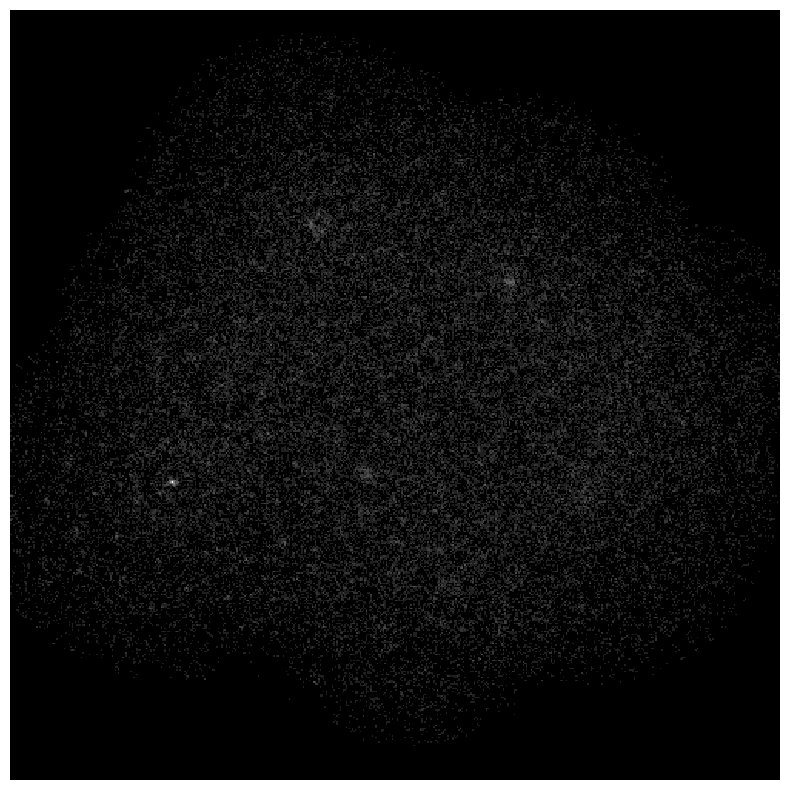

In [11]:
plt.axis('off')
plt.imshow(np.log(hough_space[:, :, 0] + 1), cmap='gray')

In [12]:
hough_space[:, :, 0] = cv2.GaussianBlur(hough_space[:, :, 0], (13, 13), 0)

In [13]:
top_5 = []

border: int = 75

hough_space_x, hough_space_y = hough_space[:, :, 0].shape

for _ in range(5):
    hough_max_x, hough_max_y = np.where(hough_space[:, :, 0] == hough_space[:, :, 0].max())
    hough_max_x, hough_max_y = hough_max_x[0], hough_max_y[0]
    top_5.append((hough_max_y, hough_max_x))
    hough_space[max(0, hough_max_x - border): min(hough_space_x, hough_max_x + border),
                max(0, hough_max_y - border): min(hough_space_y, hough_max_y + border),
                0] = 0

In [14]:
top_5

[(105, 306), (323, 174), (194, 135), (228, 296), (373, 316)]

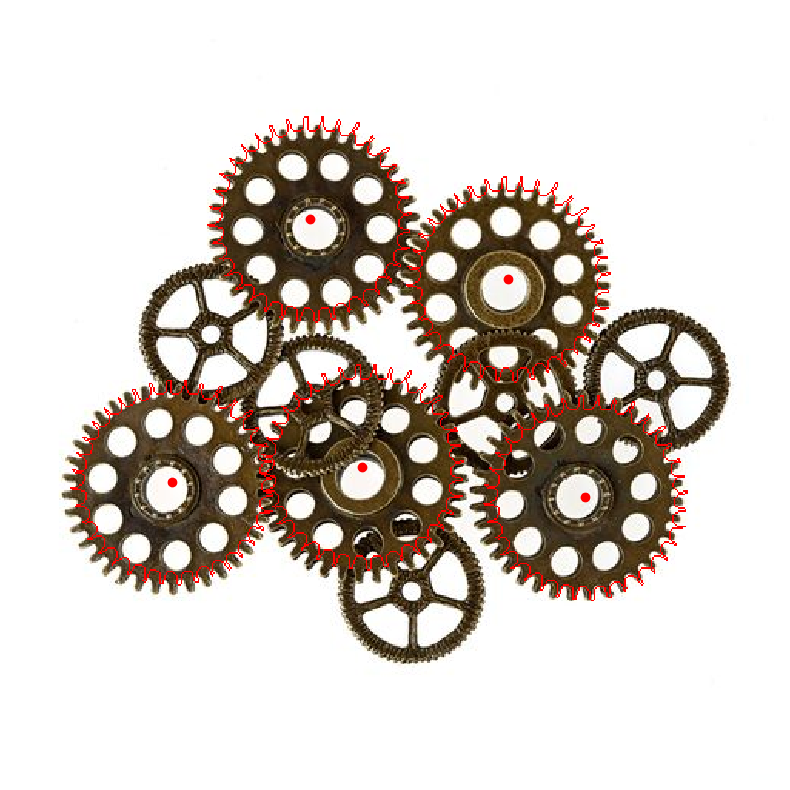

In [15]:
contours_img = cv2.imread("trybiki2.jpg")

for x, y in top_5:
    plt.plot(x, y, 'ro')
    contours_img = cv2.drawContours(contours_img, contour_list[max_index] + np.array((x, y)) - c, -1, (0, 0, 255), 1)

contours_img = cv2.cvtColor(contours_img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(contours_img)